In [1]:
import torch
import torchvision
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from multiprocessing import active_children

#### Wczytanie danych

Zbiór można pobrać używając gotowej funkcji. W zbiorze treningowym jest 50_000 przykładów, a w testowym 10_000. 
Potem 20% zbioru treningowego wykorzystuje jako zbiór walidacyjny.

In [2]:
def load_dataset(train: bool, transform: tf.Compose, download=False) -> torch.utils.data.Dataset:
    return torchvision.datasets.CIFAR10(root='./data', train=train, download=download, transform=transform)

In [3]:
basic_transform = tf.Compose([
    tf.ToTensor()
])

ds = load_dataset(train=True, transform=basic_transform, download=True)
data_loader = DataLoader(ds, batch_size=16, shuffle=True)
batch, y_hat = next(iter(data_loader))

Files already downloaded and verified


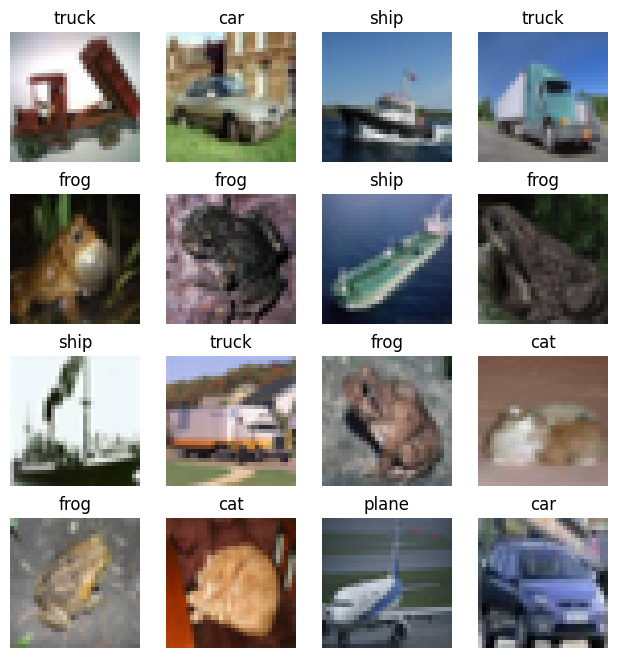

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from typing import Optional

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def plot_image_grid(
        image_batch: torch.tensor, 
        batch_classes: torch.tensor, 
        img_per_row: int = 4,
        pred_classes: Optional[torch.tensor] = None
    ):
    no_of_rows = len(batch_classes) // img_per_row
    plt.figure(figsize = (no_of_rows * 2, img_per_row * 2))
    gs = gridspec.GridSpec(no_of_rows, img_per_row)
    gs.update(wspace=0.025, hspace=0.25)
    
    for i in range(no_of_rows):
        for j in range(img_per_row):
            idx = i*no_of_rows + j
            ax = plt.subplot(gs[idx])
            img = image_batch[idx]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if pred_classes is not None:
                ax.set_title(f"{classes[batch_classes[idx]]}/{classes[pred_classes[idx]]}")
            else:
                ax.set_title(classes[batch_classes[idx]])
            ax.axis('off')
            ax.imshow(img.permute(1, 2, 0))
            
    plt.show()


plot_image_grid(batch, y_hat)

#### Architektura sieci

Architektura jest w miarę w prosta. Używam warst konwolucyjnych z filtrami 3x3 i paddingiem 1, max_poolingu 2x2 i batch normalization. Jako funkcję aktywacji przyjąłem LeakyReLU, parametr funkcji aktywacji, czyli negative_slope jest hiperparametrem modelu. W Pytorchu wagi są domyślnie inicjalizowane z użyciem Kaiming He initialization.

In [5]:
import torch.nn as nn


class Net(nn.Module):
    
    def __init__(
            self, 
            depth: int = 3,
            dropout_rate: float = 0.25,
            negative_slope: float = 0.01,
        ):
        super().__init__()

        assert 0 <= depth <= 3, "depth parameter should be between 0 and 3"

        self.dropout2D = nn.Dropout2d(dropout_rate)
        self.activation = nn.LeakyReLU(negative_slope=negative_slope)
        self.pooling2D = nn.MaxPool2d((2, 2))

        self.convolution_layers = nn.Sequential(
            self._convolutions(3, 32),
            *[
                self._convolutions(32*(2**i), 32*(2**(i+1)))
                for i in range(depth)
            ]
        )

        last_layer_side = 32 // 2**(depth + 1)
        channel_neuron_count = last_layer_side**2
        total_neuron_count = 32*(2**depth)*channel_neuron_count

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Dropout1d(dropout_rate),
            nn.Linear(total_neuron_count, 256), 
            self.activation,
            nn.Linear(256, 128),
            self.activation,
            nn.Linear(128, 10)
        )

    def _convolutions(self, in_channels: int, out_channels: int):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,

            nn.Conv2d(out_channels, out_channels, (3, 3), padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,

            self.dropout2D,
            self.pooling2D,
        )
    
    def forward(self, x):
        x = self.convolution_layers(x)
        x = self.mlp(x)
        return x
    
net = Net(depth=3)

In [6]:
out = net(batch)
out.shape

torch.Size([16, 10])

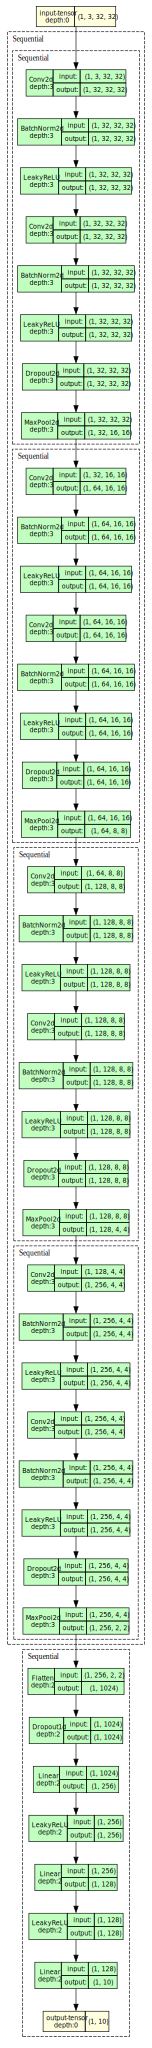

In [7]:
from torchview import draw_graph

model_graph = draw_graph(net, input_size=(1, 3, 32, 32), expand_nested=True)
model_graph.visual_graph

In [8]:
print(f"Licza parametrów sieci: {sum(p.numel() for p in net.parameters())}")

Licza parametrów sieci: 1470762


In [18]:
def choose_device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"


device = choose_device()
device

'mps'

In [19]:
import torch.optim as optim
from copy import deepcopy
from typing import Callable



# Funkcja do sprawdzania straty na zbiorze walidacyjnym po każdej epoce
def evaluate_model(
        model: nn.Module,
        val_dataset: torch.utils.data.DataLoader,
        loss_fn: Callable
    ):

    total_loss = 0.0
    number_of_batches = 0

    model = model.eval()
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            batch_loss = loss_fn(outputs, labels)
            total_loss += batch_loss.item()
            number_of_batches += 1

    average_loss = total_loss / number_of_batches

    return average_loss


# Rysowanie wartości straty w każdej epoce
def plot_training_stats(train_loss: list[float], val_loss: list[float]):

    epochs = len(train_loss)
    plt.xticks(range(0, epochs, 3))

    plt.plot(train_loss, color='red', label="Training loss")
    plt.plot(val_loss, color='blue', label="Validation loss")

    plt.xlabel("Epoch number")
    plt.ylabel("Average batch loss")

    plt.legend()
    plt.show()
    

def train_model(
        model: nn.Module, 
        train_dataset: DataLoader, 
        val_dataset: DataLoader,
        optim_method: str = "AdamW",
        max_epochs: int = 50,
        patience: int = 3,
        l2_reg: float = 2*1e-5,
        logging_step: int = 1
    ):


    def _get_core_optimizer(name: str):
        return getattr(optim, name)


    optimizer = _get_core_optimizer(optim_method)(model.parameters(), weight_decay=l2_reg)
    criterion = nn.CrossEntropyLoss()

    best_model, best_loss = model, float("inf")
    steps_without_improvement = 0
    train_losses, val_losses = [], []

    for epoch in range(max_epochs):
        epoch_loss = 0.0
        number_of_batches = 0
        model = model.train()

        for inputs, labels in train_dataset:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            batch_loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        
            epoch_loss += batch_loss.item()
            number_of_batches += 1
        
        train_loss = epoch_loss / number_of_batches
        train_losses.append(train_loss)

        val_loss = evaluate_model(model, val_dataset, criterion)
        val_losses.append(val_loss)

        if epoch % logging_step == 0:
            print(f"Epoch {epoch}")
            print(f"Train average loss: {train_loss:.3f}, Validation average loss: {val_loss:.3f}\n")

        if val_loss < best_loss:
            steps_without_improvement = 0
            best_loss = val_loss
            best_model = deepcopy(model)
        else:
            steps_without_improvement += 1
            if steps_without_improvement > patience:
                print("Early stopping")
                break 

    plot_training_stats(train_losses, val_losses)
    return best_model

In [20]:
transform = tf.Compose([
    tf.ToTensor(),
    tf.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
])

train_dataset = load_dataset(train=True, transform=transform)
test_dataset = load_dataset(train=False, transform=transform)
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_dataset, [0.8, 0.2])


train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)
val_data_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, persistent_workers=True)
test_data_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Epoch 0
Train average loss: 1.839, Validation average loss: 1.451

Epoch 1
Train average loss: 1.618, Validation average loss: 1.265

Epoch 2
Train average loss: 1.475, Validation average loss: 1.050

Epoch 3
Train average loss: 1.374, Validation average loss: 1.007

Epoch 4
Train average loss: 1.302, Validation average loss: 0.883

Epoch 5
Train average loss: 1.242, Validation average loss: 0.848

Epoch 6
Train average loss: 1.193, Validation average loss: 0.826

Epoch 7
Train average loss: 1.161, Validation average loss: 0.732

Epoch 8
Train average loss: 1.121, Validation average loss: 0.735

Epoch 9
Train average loss: 1.099, Validation average loss: 0.665

Epoch 10
Train average loss: 1.060, Validation average loss: 0.662

Epoch 11
Train average loss: 1.041, Validation average loss: 0.623

Epoch 12
Train average loss: 1.018, Validation average loss: 0.622

Epoch 13
Train average loss: 0.997, Validation average loss: 0.592

Epoch 14
Train average loss: 0.972, Validation average los

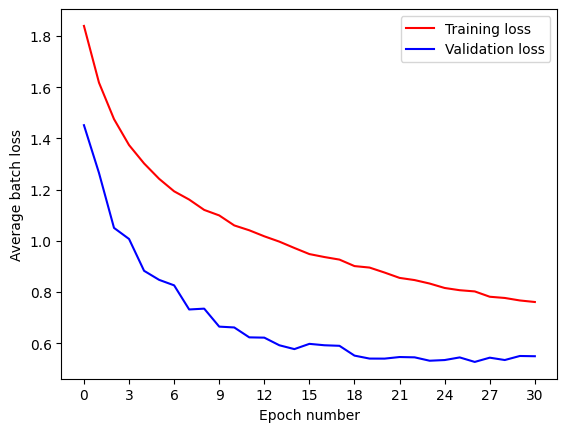

In [12]:
net = Net()
net.to(device)
net = train_model(net, train_data_loader, val_data_loader)

In [14]:
# Usuwanie data_loaderów (Podprocesy cały czas działają z powodu użycia flagi persistent_workers)

del train_data_loader
del val_data_loader
active_children()

[]

In [20]:
torch.save(net.state_dict(), "saved_models/initial_model")

In [21]:
def compute_test_accuracy(net: Net, data_loader: DataLoader):
    correct_per_class = torch.zeros(10)
    total_per_class = torch.zeros(10)

    net = net.eval()
    net.to("cpu")
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)

            correct_labels = labels == predictions
            for i in range(10):
                correct_per_class[i] += (correct_labels & (labels == i)).sum()
                total_per_class[i] += (labels == i).sum()
    
    for i in range(10):
        print(f"{classes[i]}: {(100*correct_per_class[i] / total_per_class[i]):.2f}%")

    print(f"\nTotal accuracy: {(100*correct_per_class.sum() / total_per_class.sum()):.2f}%")

In [16]:
compute_test_accuracy(net, test_data_loader)

plane accuracy: 87.90%
car accuracy: 91.00%
bird accuracy: 70.40%
cat accuracy: 59.70%
deer accuracy: 80.40%
dog accuracy: 79.90%
frog accuracy: 87.50%
horse accuracy: 84.70%
ship accuracy: 89.70%
truck accuracy: 90.10%

Total accuracy: 82.13%


Na ustawieniach domyślnych model ma 82.13% skuteczności na zbiorze testowym.

In [21]:
del net

#### Trening hiperparametrów

Jako hiperparametry modelu przyjąłem rozmiar batcha w trakcie ładowania danych, głebokość sieci (ilość warstw konwolucyjnych), dropout_rate, negative_slope w LeakyRelu, współczynnik przy regularyzacji l2 i rodzaj optimizera (Adam lub AdamW). Przy szukaniu parametrów optymalizowaną funkcją jest accuracy na zbiorze walidacyjnym. Używam także early stoppingu. 

In [22]:
import optuna


def val_dataset_accuracy(net: Net, data_loader: DataLoader):
    correct, total = 0, 0
    net = net.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)

            correct += (labels == predictions).sum()
            total += len(labels)

    return correct / total


def objective(trial):

    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256, 512])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
    
    
    depth = trial.suggest_int("depth", 0, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    negative_slope = trial.suggest_float("negative_slope", 0.01, 0.1, log=True)

    net = Net(depth, dropout_rate, negative_slope)
    net.to(device)


    l2_reg = trial.suggest_float("l2_reg", 0.00005, 0.001)
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    
    net = train_model(
        model=net,
        train_dataset=train_loader,
        val_dataset=val_loader,
        optim_method=optimizer,
        l2_reg=l2_reg,
        logging_step=5
    )

    accuracy = val_dataset_accuracy(net, val_loader)
    
    net.to("cpu")
    del val_loader, train_loader, net
    
    return accuracy


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [32]:
for i, trial in enumerate(study.get_trials()):
    print(f"Trial {i}, accuracy: {100*trial._values[0]:.2f}%")

Trial 0, accuracy: 77.48%
Trial 1, accuracy: 81.18%
Trial 2, accuracy: 77.79%
Trial 3, accuracy: 79.88%
Trial 4, accuracy: 79.56%
Trial 5, accuracy: 72.55%
Trial 6, accuracy: 81.12%
Trial 7, accuracy: 79.31%
Trial 8, accuracy: 69.76%
Trial 9, accuracy: 70.14%
Trial 10, accuracy: 76.87%
Trial 11, accuracy: 77.40%
Trial 12, accuracy: 82.20%
Trial 13, accuracy: 81.94%
Trial 14, accuracy: 82.09%
Trial 15, accuracy: 80.52%
Trial 16, accuracy: 78.32%
Trial 17, accuracy: 81.59%
Trial 18, accuracy: 82.64%
Trial 19, accuracy: 81.36%


In [34]:
best_params = study.best_params
print(f"Best parameters: {best_params}")


Best parameters: {'batch_size': 64, 'depth': 3, 'dropout_rate': 0.2770095952592047, 'negative_slope': 0.07484088242573692, 'l2_reg': 0.0006965805689199912, 'optimizer': 'AdamW'}


In [35]:
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

Epoch 0
Train average loss: 1.907, Validation average loss: 1.522

Epoch 1
Train average loss: 1.680, Validation average loss: 1.262

Epoch 2
Train average loss: 1.547, Validation average loss: 1.190

Epoch 3
Train average loss: 1.450, Validation average loss: 1.022

Epoch 4
Train average loss: 1.389, Validation average loss: 0.988

Epoch 5
Train average loss: 1.339, Validation average loss: 0.880

Epoch 6
Train average loss: 1.294, Validation average loss: 0.848

Epoch 7
Train average loss: 1.248, Validation average loss: 0.814

Epoch 8
Train average loss: 1.214, Validation average loss: 0.768

Epoch 9
Train average loss: 1.191, Validation average loss: 0.763

Epoch 10
Train average loss: 1.150, Validation average loss: 0.679

Epoch 11
Train average loss: 1.137, Validation average loss: 0.655

Epoch 12
Train average loss: 1.120, Validation average loss: 0.649

Epoch 13
Train average loss: 1.090, Validation average loss: 0.629

Epoch 14
Train average loss: 1.073, Validation average los

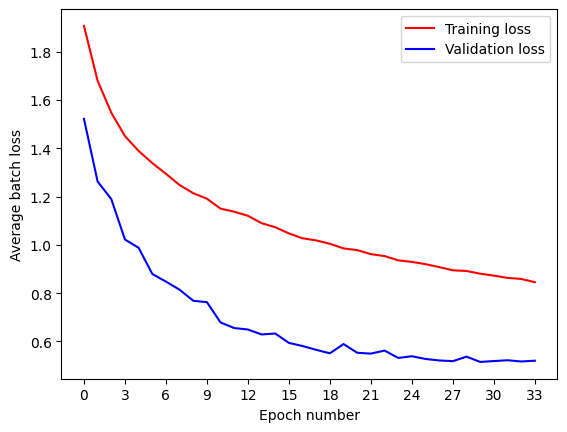

In [36]:
net = Net(depth=best_params["depth"], dropout_rate=study.best_params["dropout_rate"], negative_slope=best_params["negative_slope"])
net.to(device)
net = train_model(net, train_data_loader, val_data_loader, l2_reg=best_params["l2_reg"], optim_method=best_params["optimizer"])

In [37]:
torch.save(net.state_dict(), "saved_models/best_model")

In [38]:
compute_test_accuracy(net, test_data_loader)

plane accuracy: 85.30%
car accuracy: 91.80%
bird accuracy: 72.50%
cat accuracy: 64.70%
deer accuracy: 78.90%
dog accuracy: 78.20%
frog accuracy: 89.60%
horse accuracy: 87.80%
ship accuracy: 87.50%
truck accuracy: 91.90%

Total accuracy: 82.82%


Po treningu hiperparametrów skuteczność modelu podniosła się o około 0.7%.

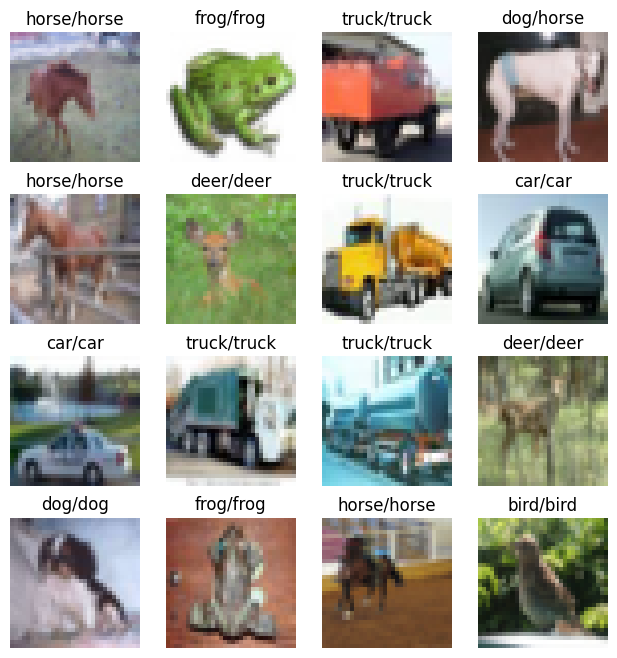

In [49]:
batch, batch_classes = next(iter(train_data_loader))
batch, batch_classes = batch[:16], batch_classes[:16]
_, pred = torch.max(net(batch), 1)

batch = batch * 0.2 + 0.5 # Odwrócenie normalizacji, dla lepszej jakości zdjęć
plot_image_grid(batch, batch_classes=batch_classes, pred_classes=pred)